In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [12]:
df_pr = df[(df.table_id == 'day') & (df.variable_id == 'pr') & (df.source_id == 'NorESM2-LM')]
len(df_pr.table_id)

12

In [16]:
def load_pr_data(expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_pr[(df_pr.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [108]:
hist = load_pr_data('historical').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()
ssp245 = load_pr_data('ssp245').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()

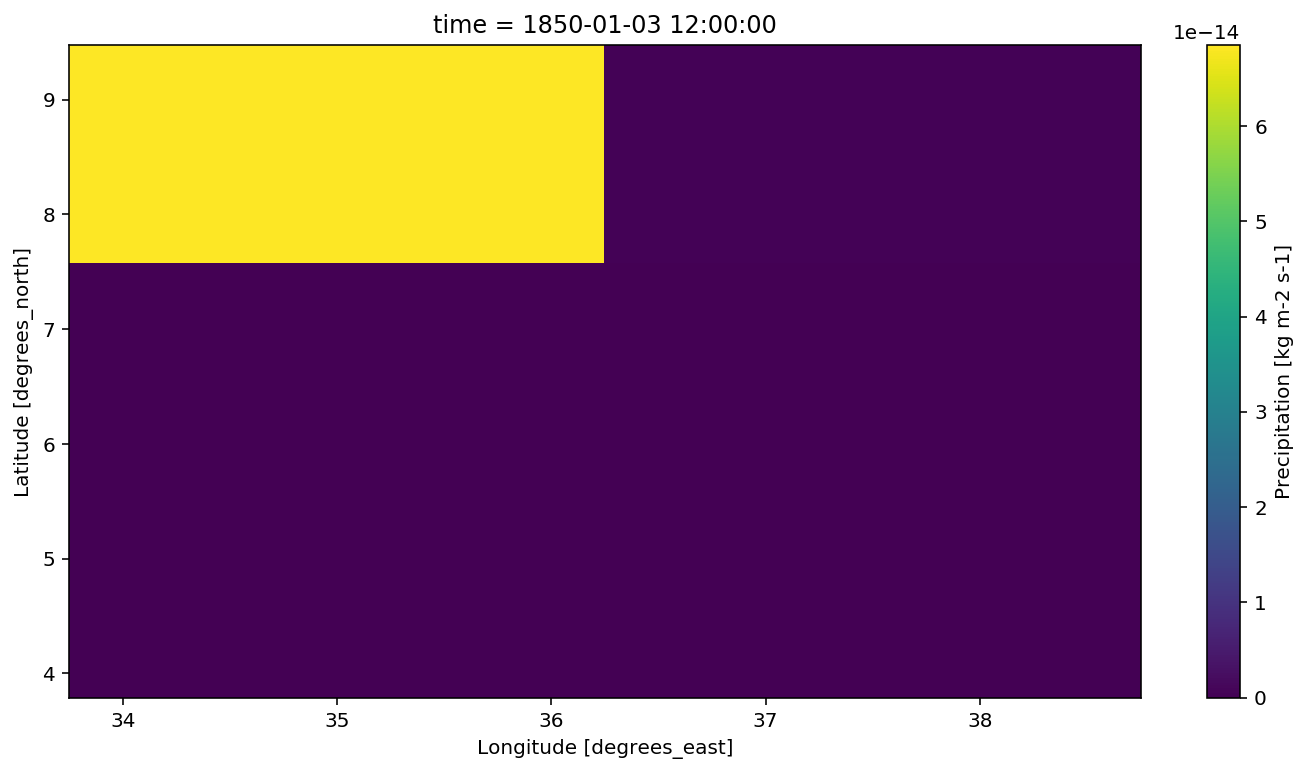

In [109]:
#plt.figure(figsize=(16,8))
# ax = plt.axes()
hist.pr.isel(time=2).sel(lat=slice(4, 10)).sel(lon=slice(32,39)).plot()
# plt.xlim(34,40)
# omo.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)
# plt.show()
# hist.isel(time = 0).plot()

In [110]:
dir_ls = ['SW', 'SE', 'W', 'E', 'NW', 'NW']
ls = {}
i = 0
for lat in hist.lat:
    for lon in hist.lon:
        pr_ts = hist.pr.sel(lat=lat).sel(lon=lon)
        ls[dir_ls[i]] = pr_ts
        i+=1
        

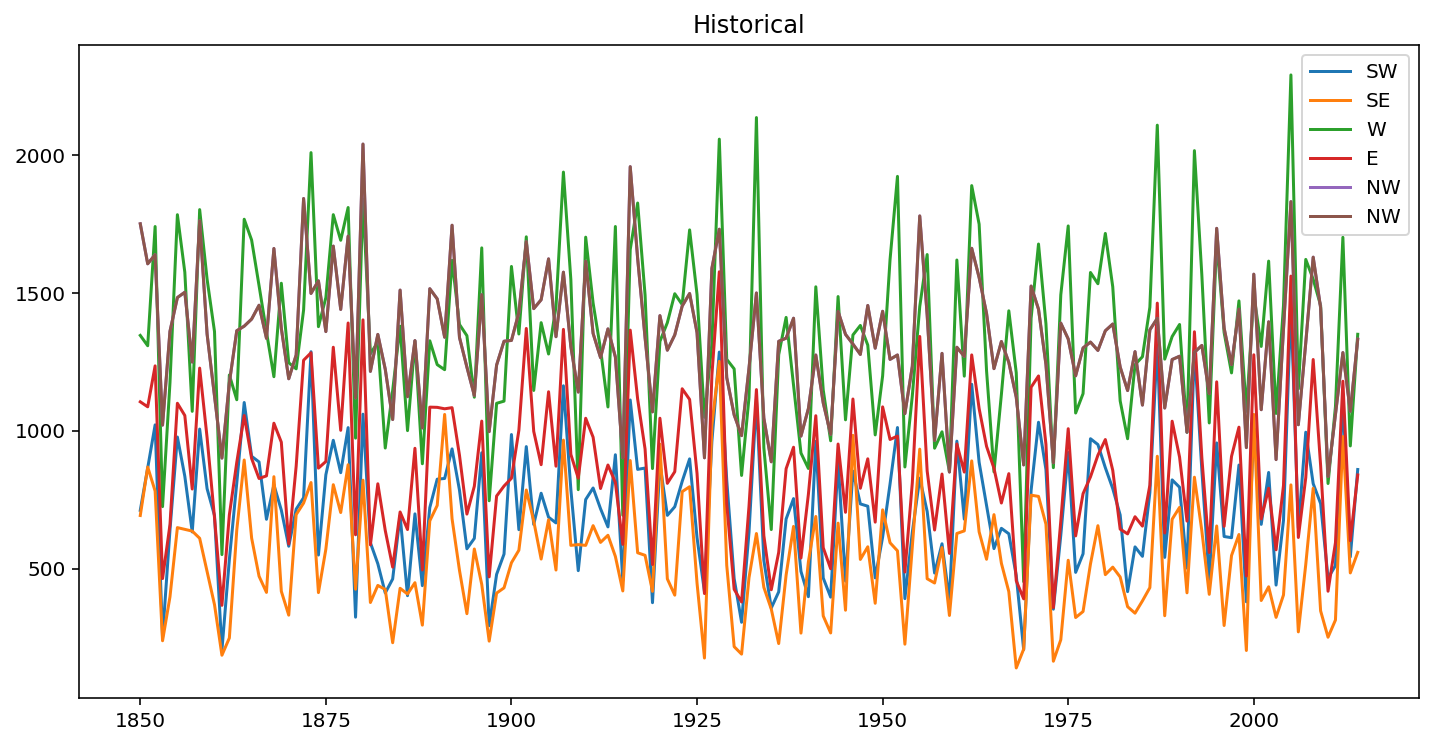

In [111]:
import datetime as dt

for item in dir_ls:
    df = pd.DataFrame({'date':ls[item].time, 'pr':ls[item]*86400})
    df['date'] =  df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby(df['date'].dt.year).sum()
    plt.plot(df.index, df.pr, label = item)

plt.legend()
plt.title("Historical")
plt.show()

# plt.plot(ls['N'].time, ls['N'] * 86400)
# plt.show()

In [112]:
# dir_ls = ['SW', 'S', 'SE', 'W', 'C', 'E', 'NW', 'N', 'NW']
ssp245_pix = {}
i = 0
for lat in ssp245.lat:
    for lon in ssp245.lon:
        pr_ts = ssp245.pr.sel(lat=lat).sel(lon=lon)
        ssp245_pix[dir_ls[i]] = pr_ts
        i+=1

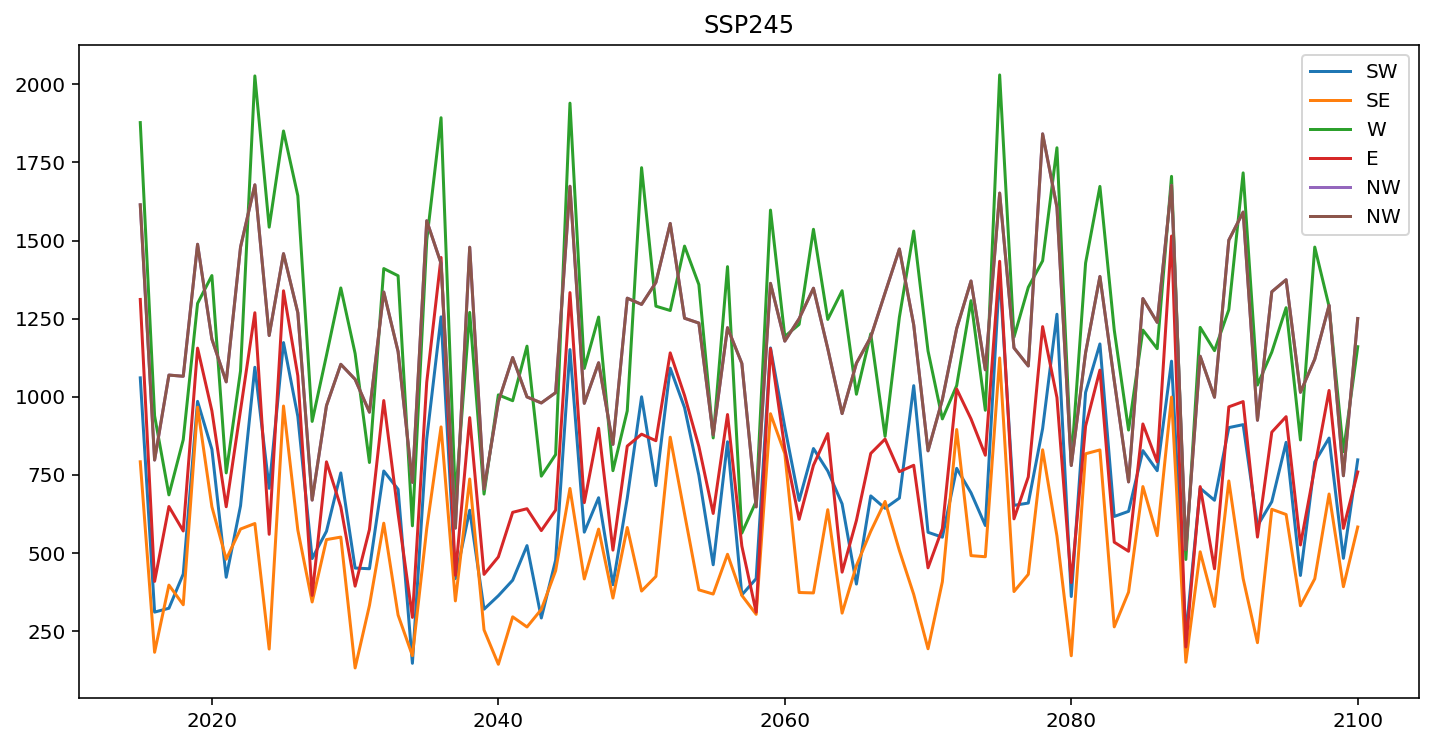

In [113]:
for item in dir_ls:
    df2 = pd.DataFrame({'date':ssp245_pix[item].time, 'pr':ssp245_pix[item]*86400})
    df2['date'] =  df2['date'].astype(str)
    df2['date'] = pd.to_datetime(df2['date'])
    df2 = df2.groupby(df2['date'].dt.year).sum()
    plt.plot(df2.index, df2.pr, label = item)

plt.legend()
plt.title("SSP245")
plt.show()

# plt.plot(ls['N'].time, ls['N'] * 86400)
# plt.show()

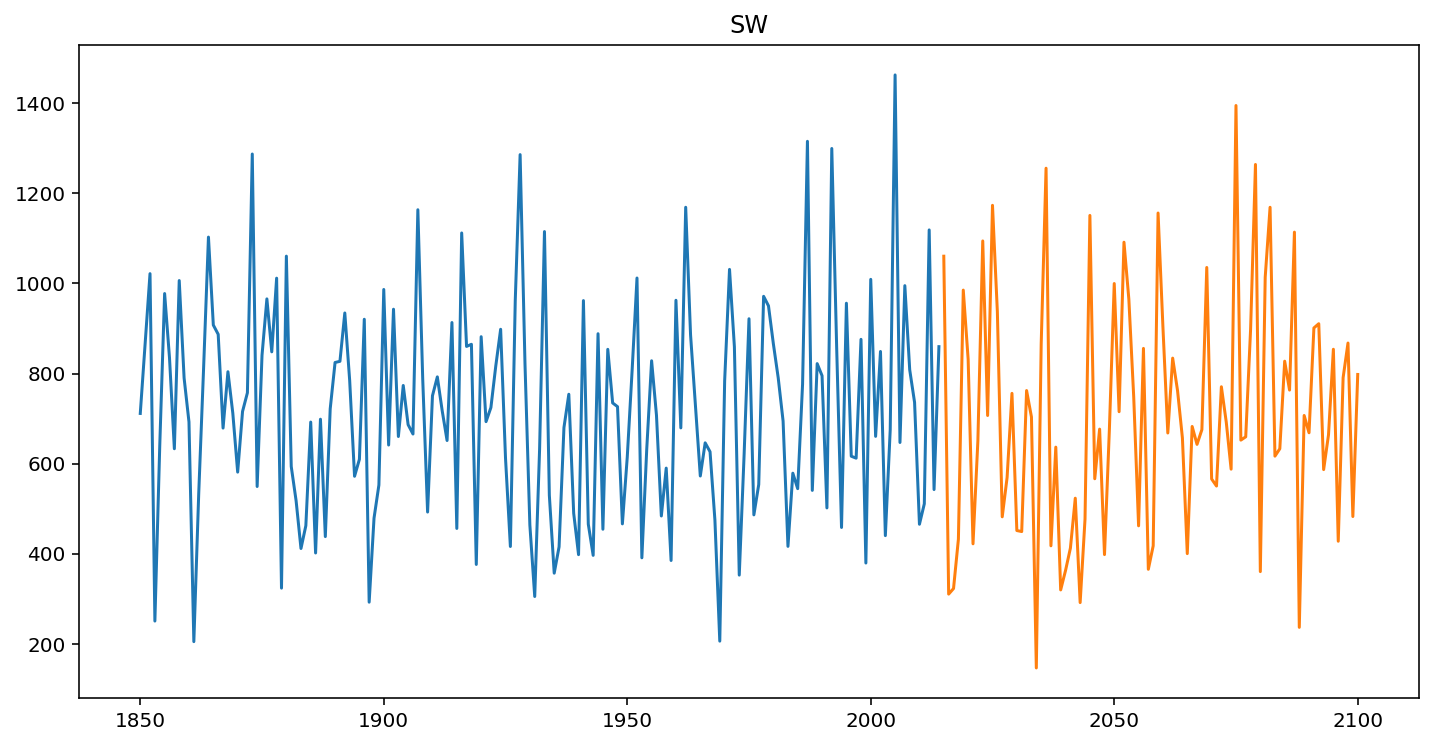

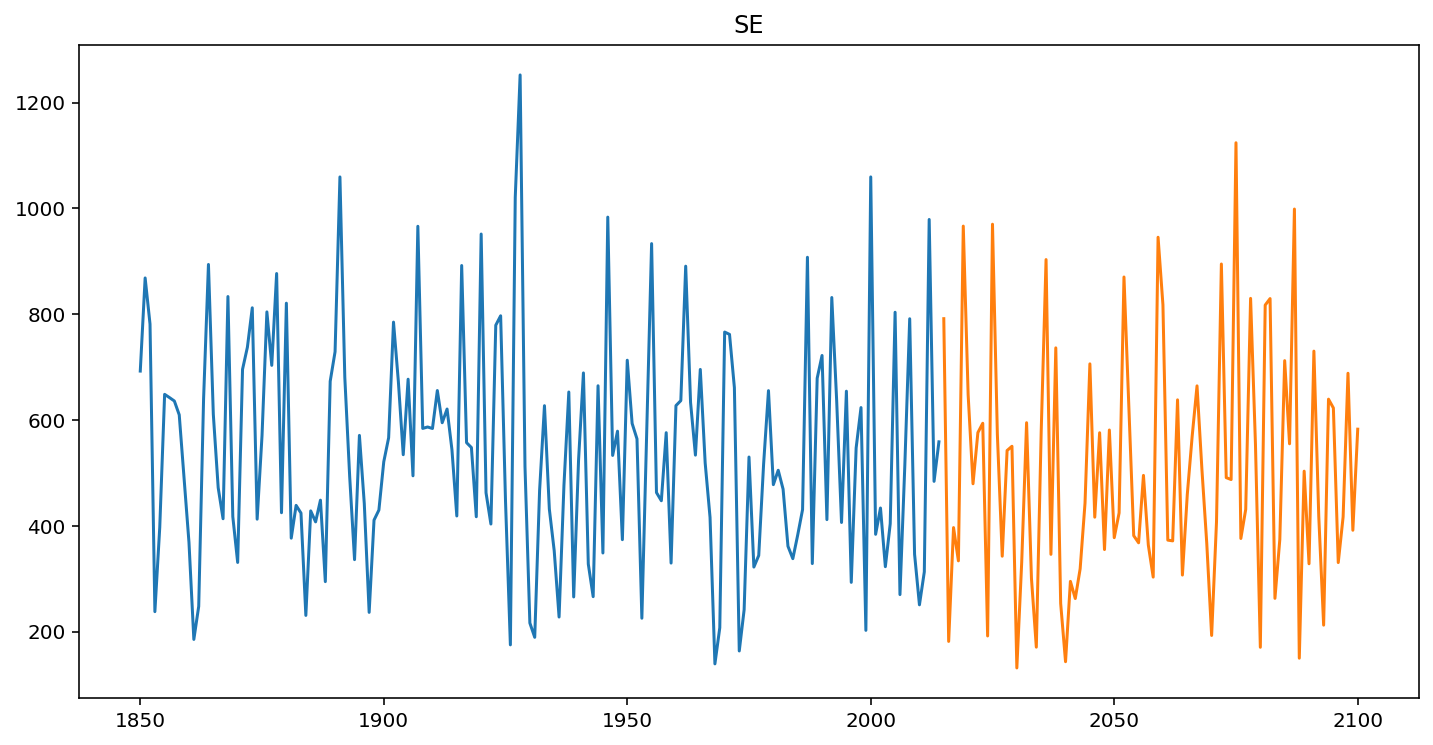

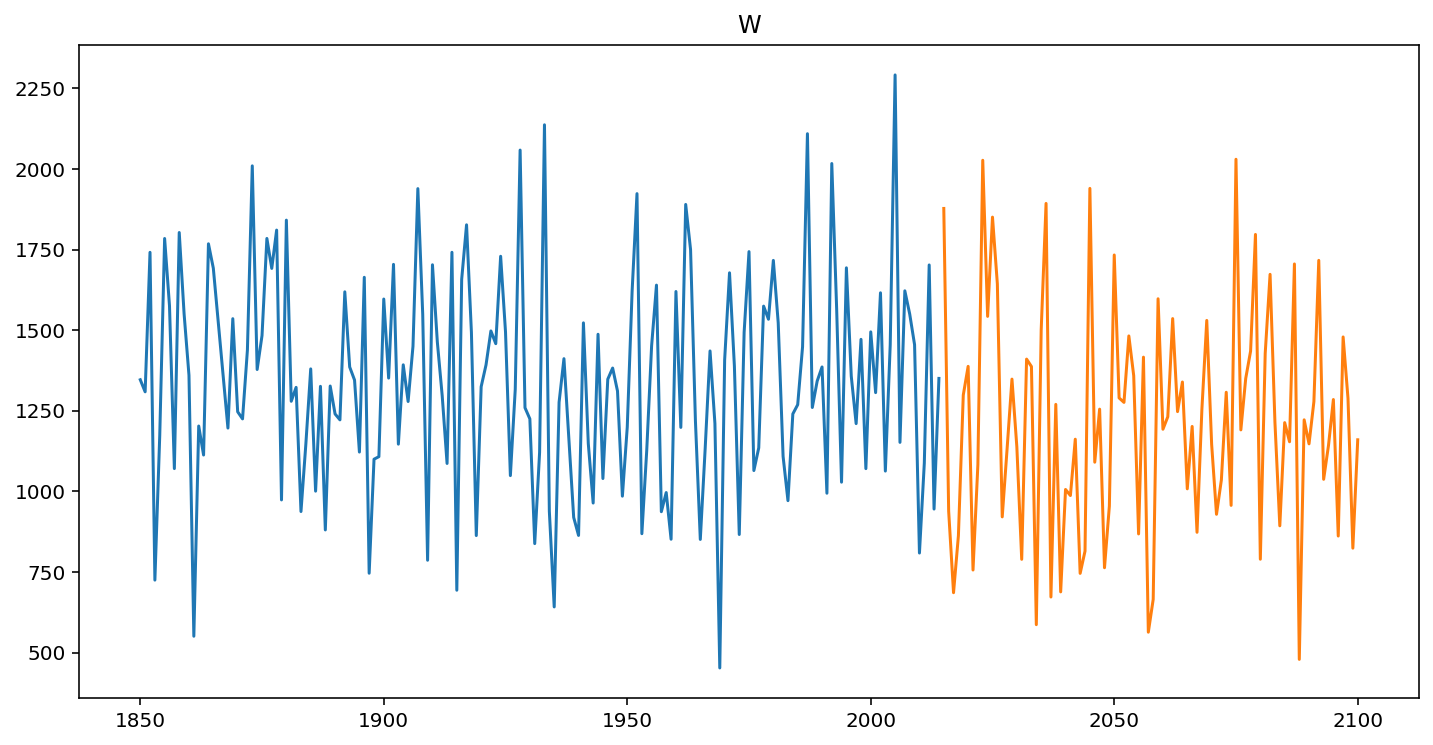

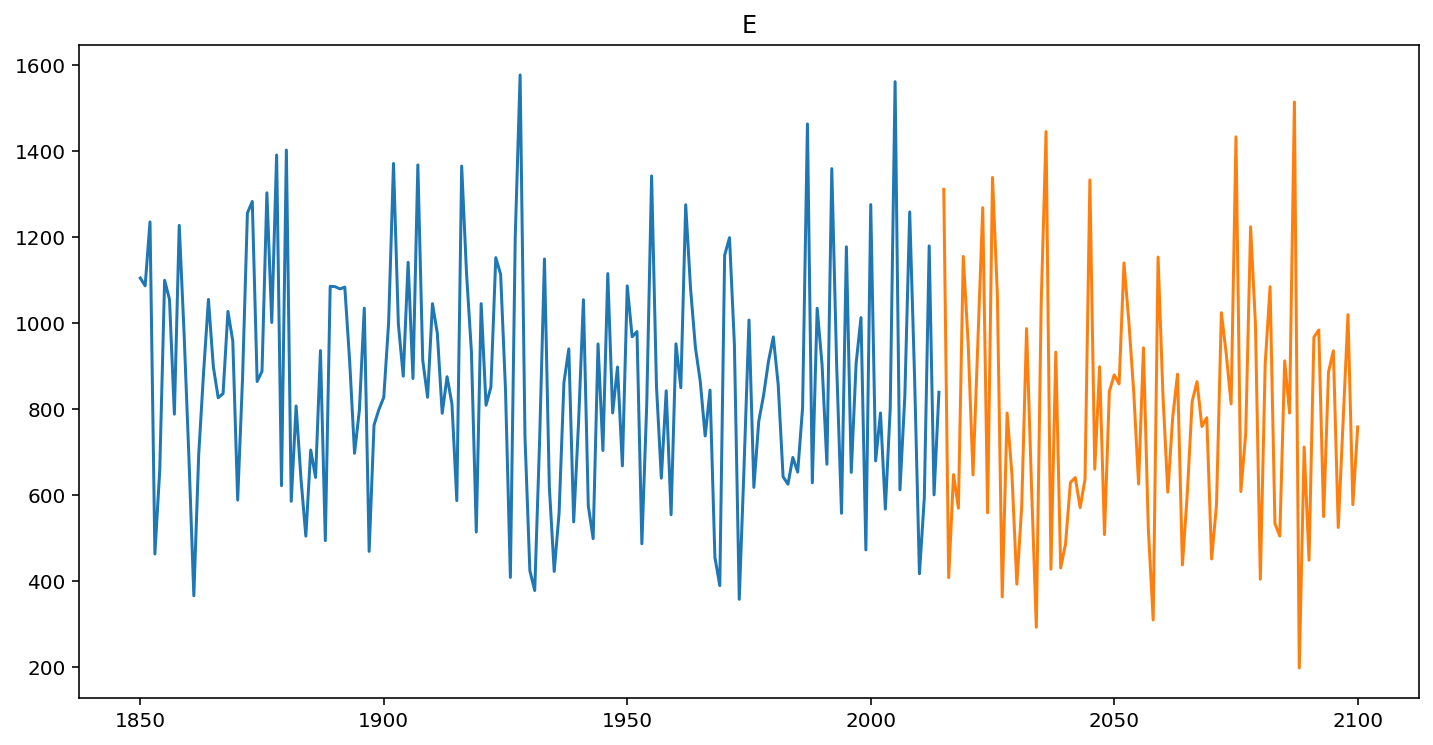

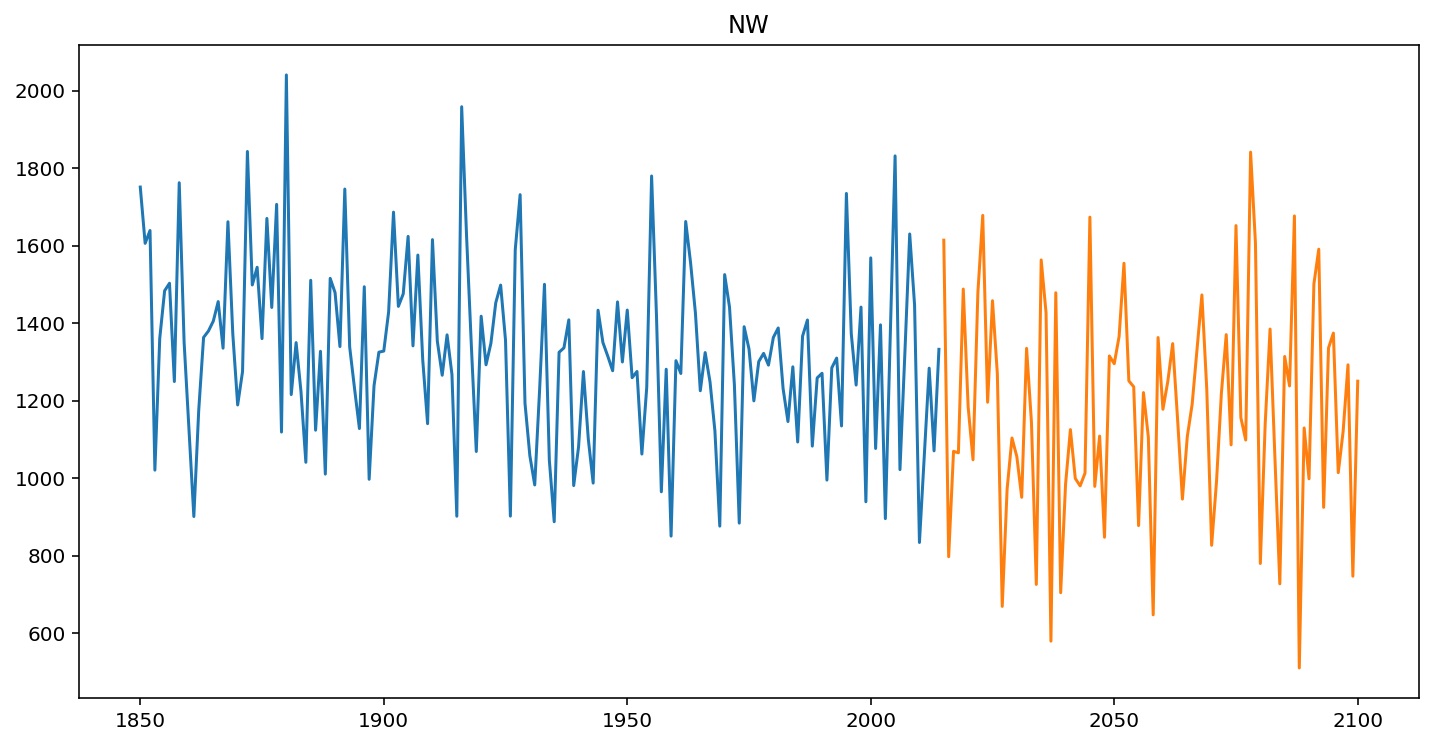

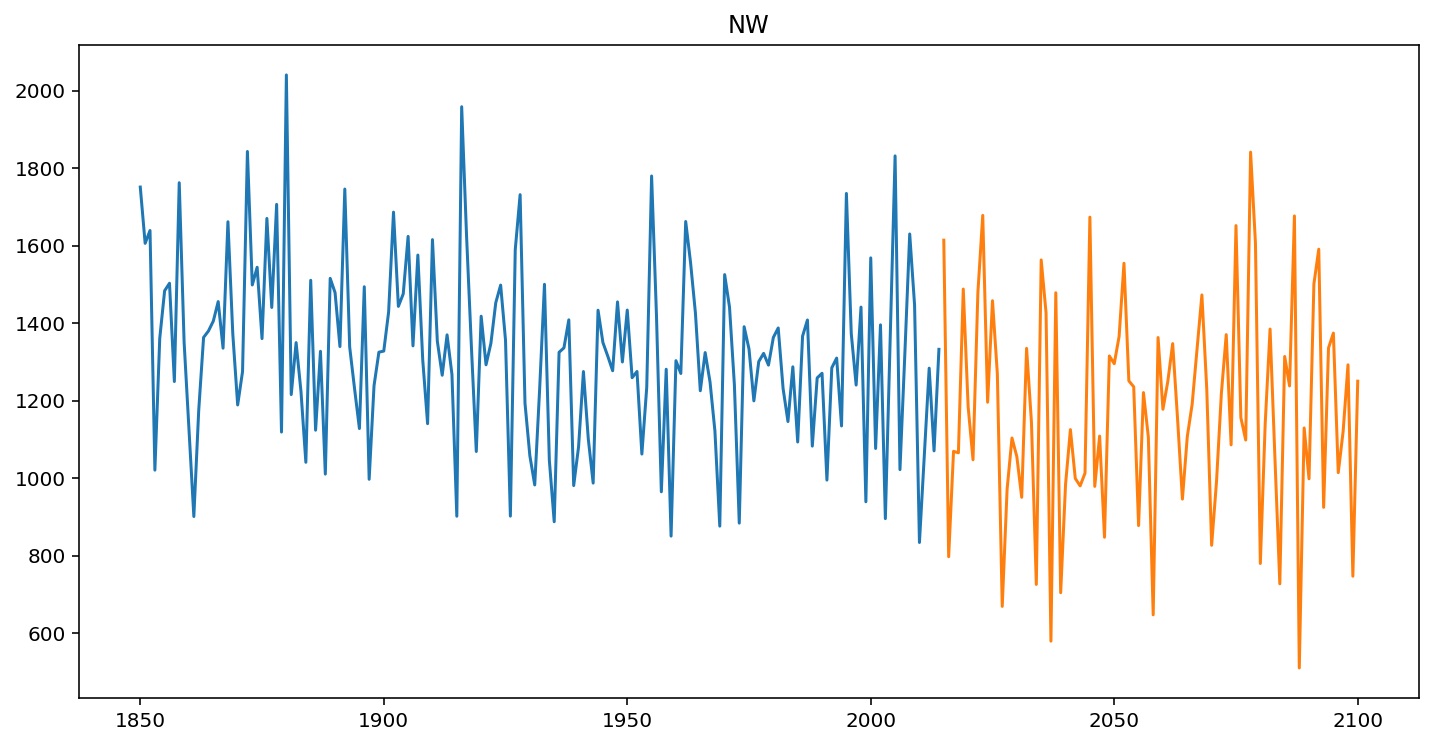

In [114]:
for item in dir_ls:
    df =  pd.DataFrame({'date': ls[item].time, 'pr':ls[item]*86400})
    df['date'] =  df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby(df['date'].dt.year).sum()

    df2 = pd.DataFrame({'date':ssp245_pix[item].time, 'pr':ssp245_pix[item]*86400})
    df2['date'] =  df2['date'].astype(str)
    df2['date'] = pd.to_datetime(df2['date'])
    df2 = df2.groupby(df2['date'].dt.year).sum()
    
    plt.plot(df.index, df.pr)
    plt.plot(df2.index, df2.pr)
    plt.title(item)
    plt.show()

# plt.plot(ls['N'].time, ls['N'] * 86400)
# plt.show()

In [102]:
import geopandas 
# import rioxarray
from shapely.geometry import mapping 
omo = geopandas.read_file('subs1.shp', crs="epsg:32637")
omo.crs = {'init' :"epsg:32637"}
omo = omo.to_crs({'init': 'epsg:4326'})
# omo = omo.to_crs("EPSG:4326")

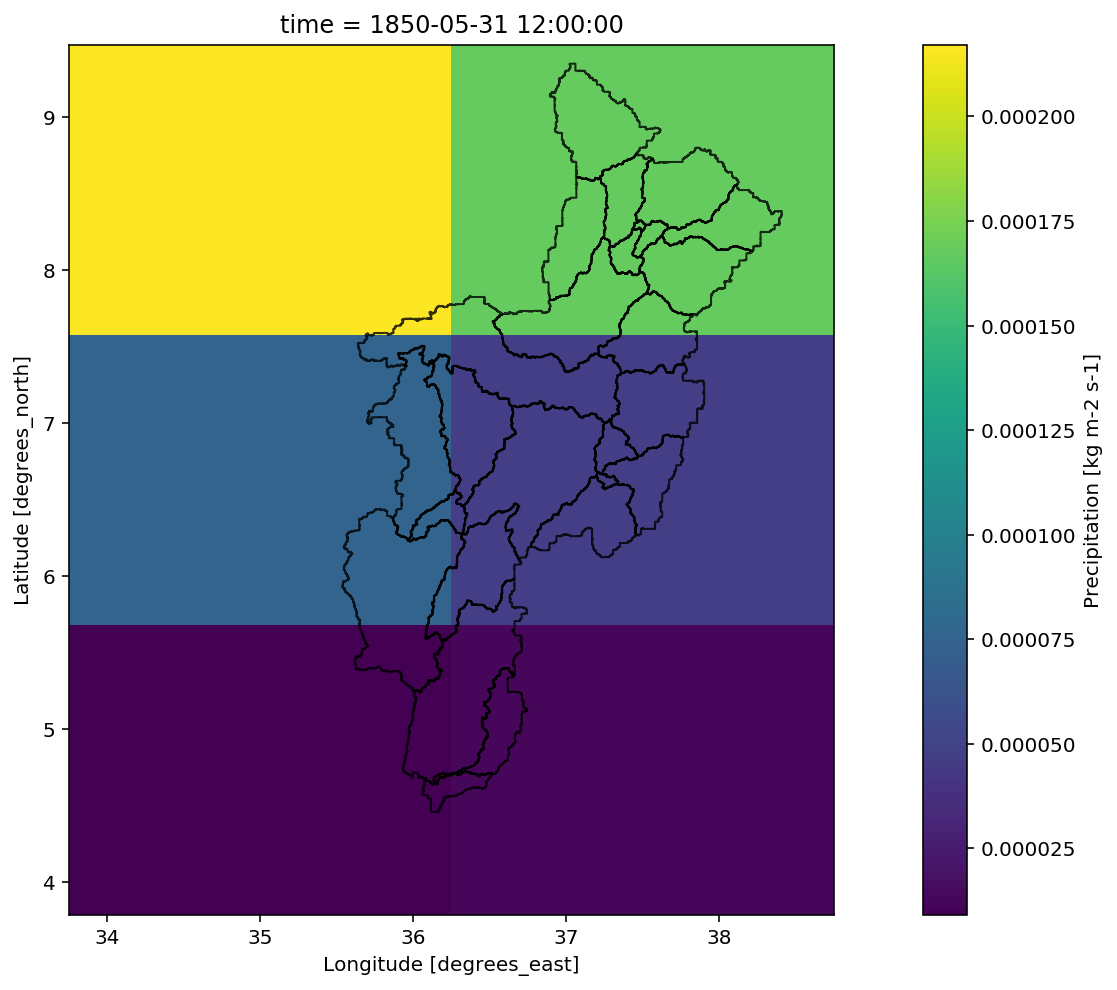

In [116]:
plt.figure(figsize=(16,8))
ax = plt.axes()
hist.pr.isel(time=150).sel(lat=slice(4, 10)).sel(lon=slice(32,39)).plot(ax=ax)

omo.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)


# hist.pr.isel(time=2).sel(lat=slice(4, 10)).sel(lon=slice(32,39)).plot()
# omo.plot()

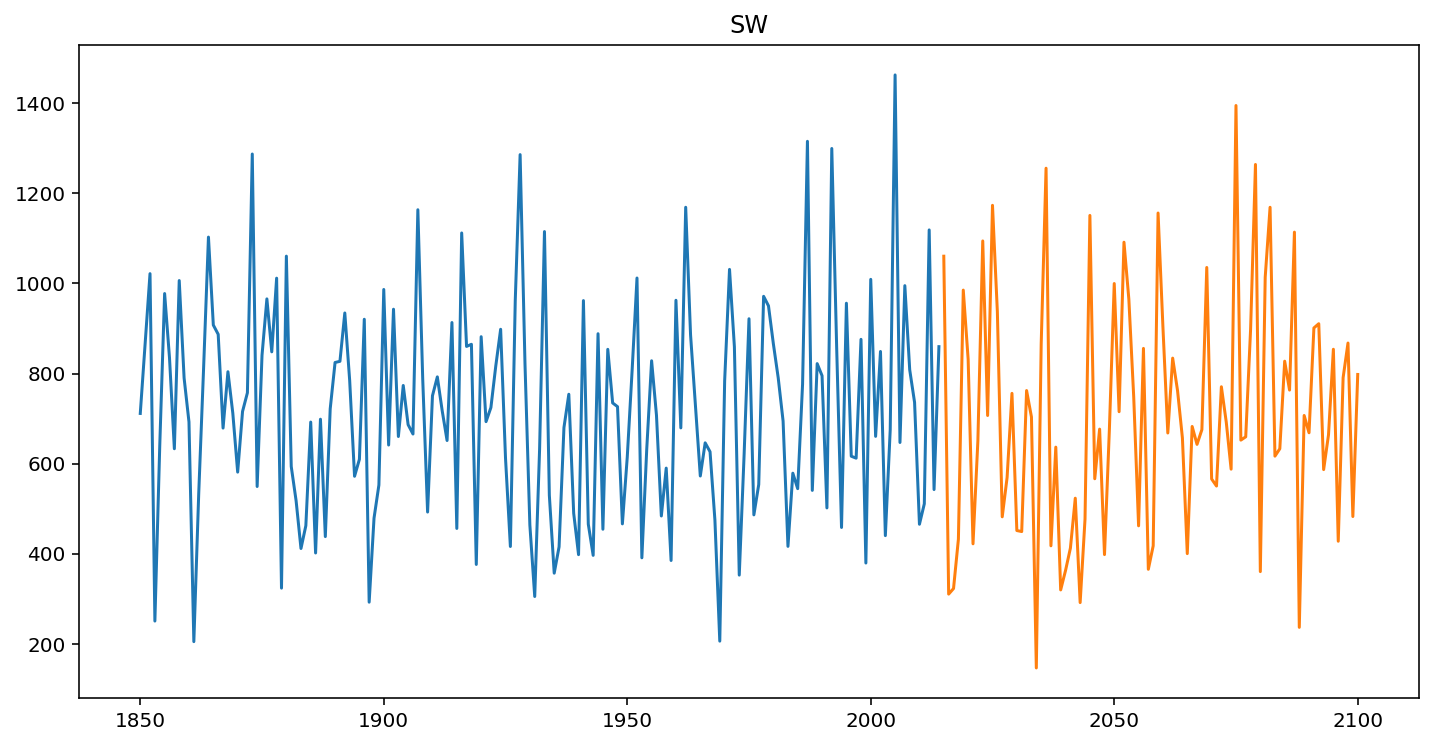

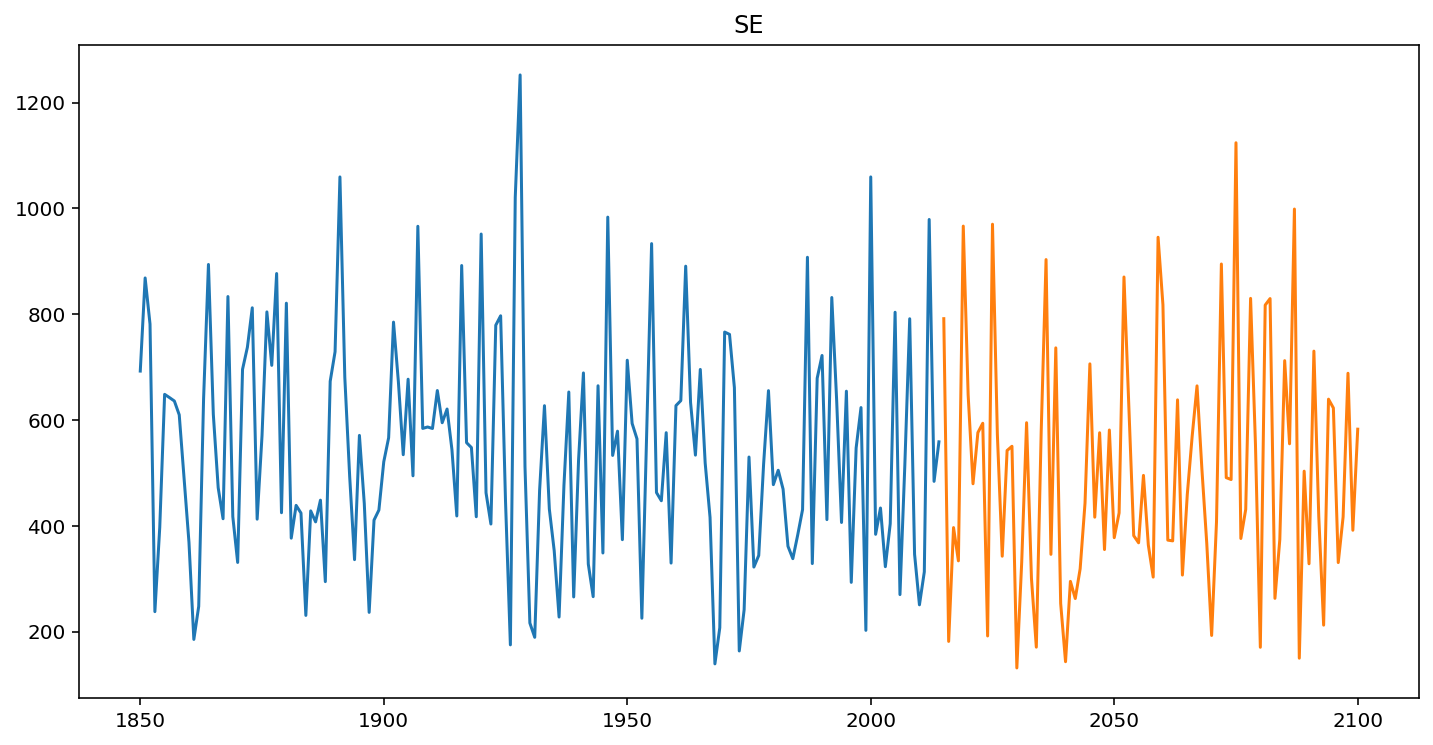

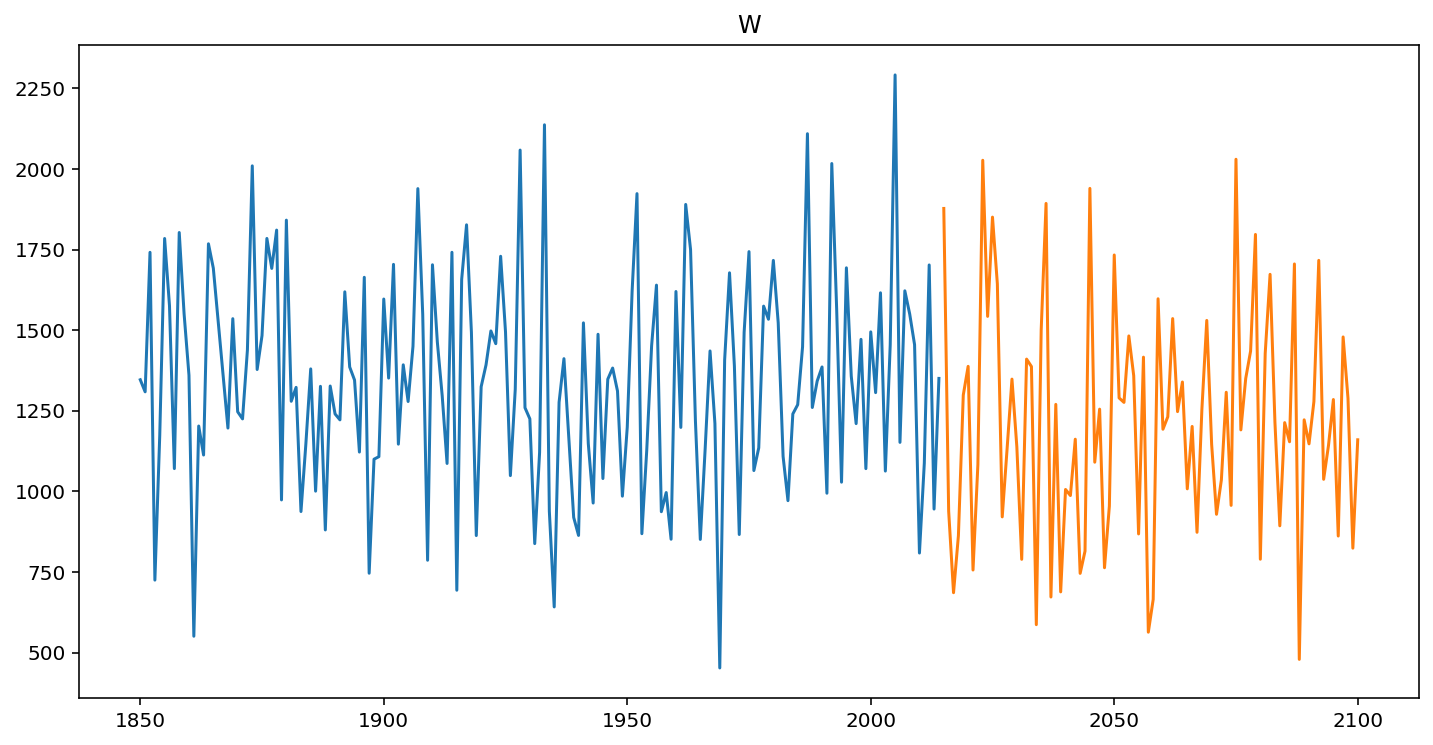

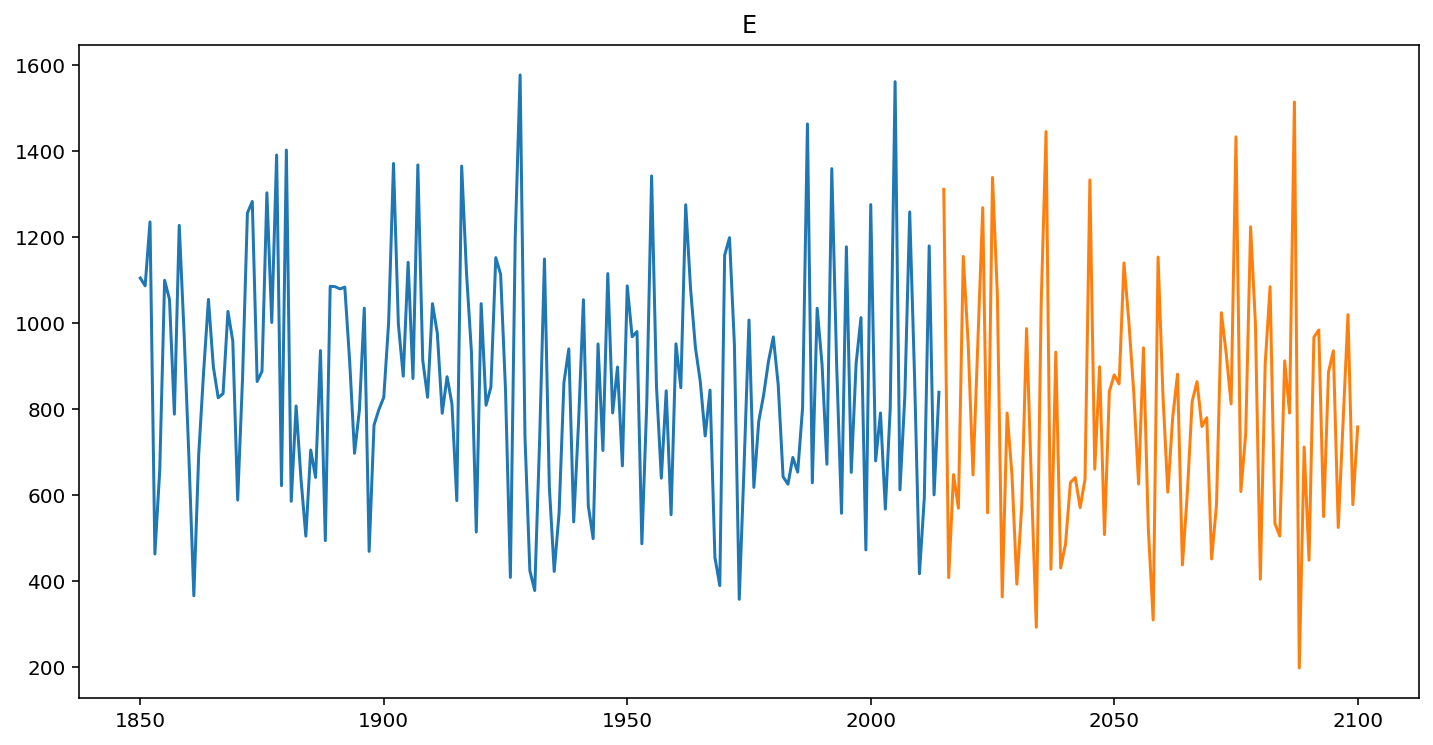

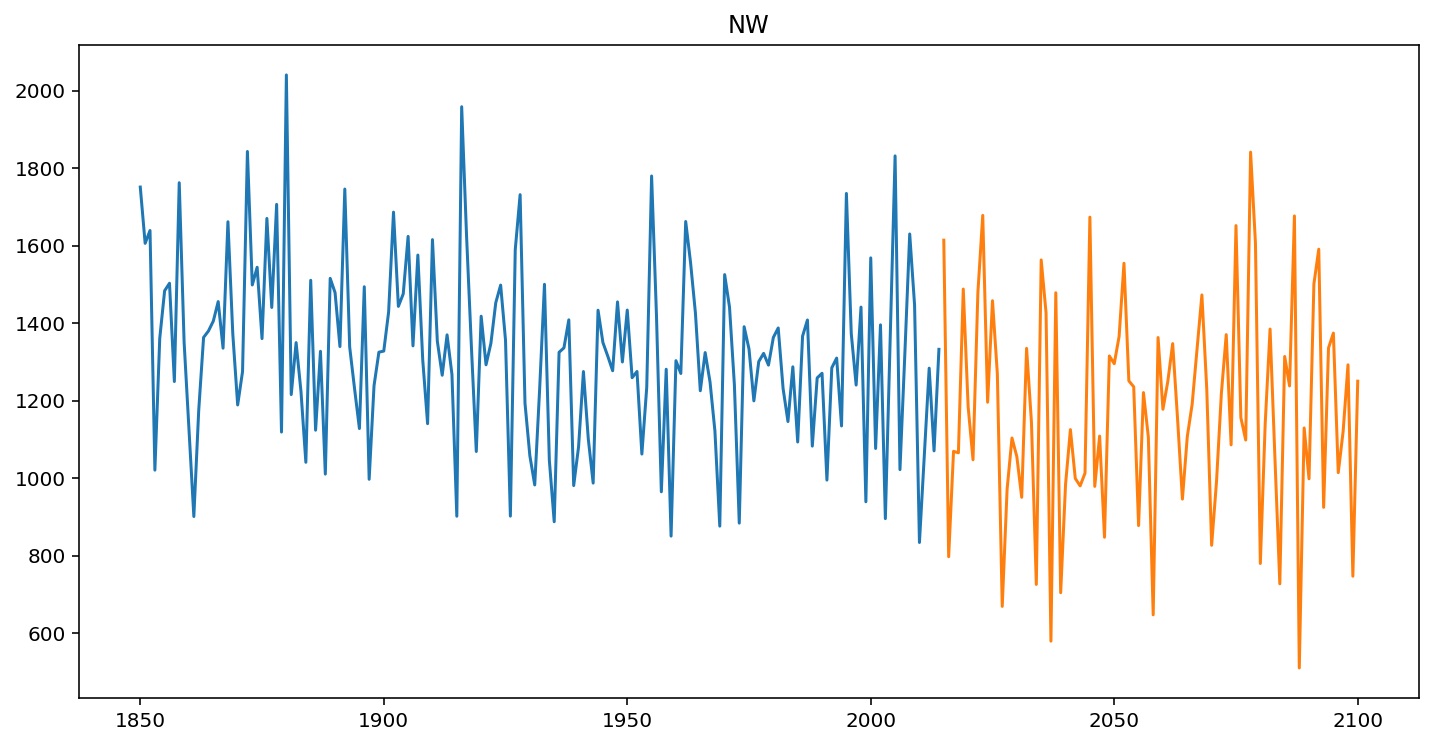

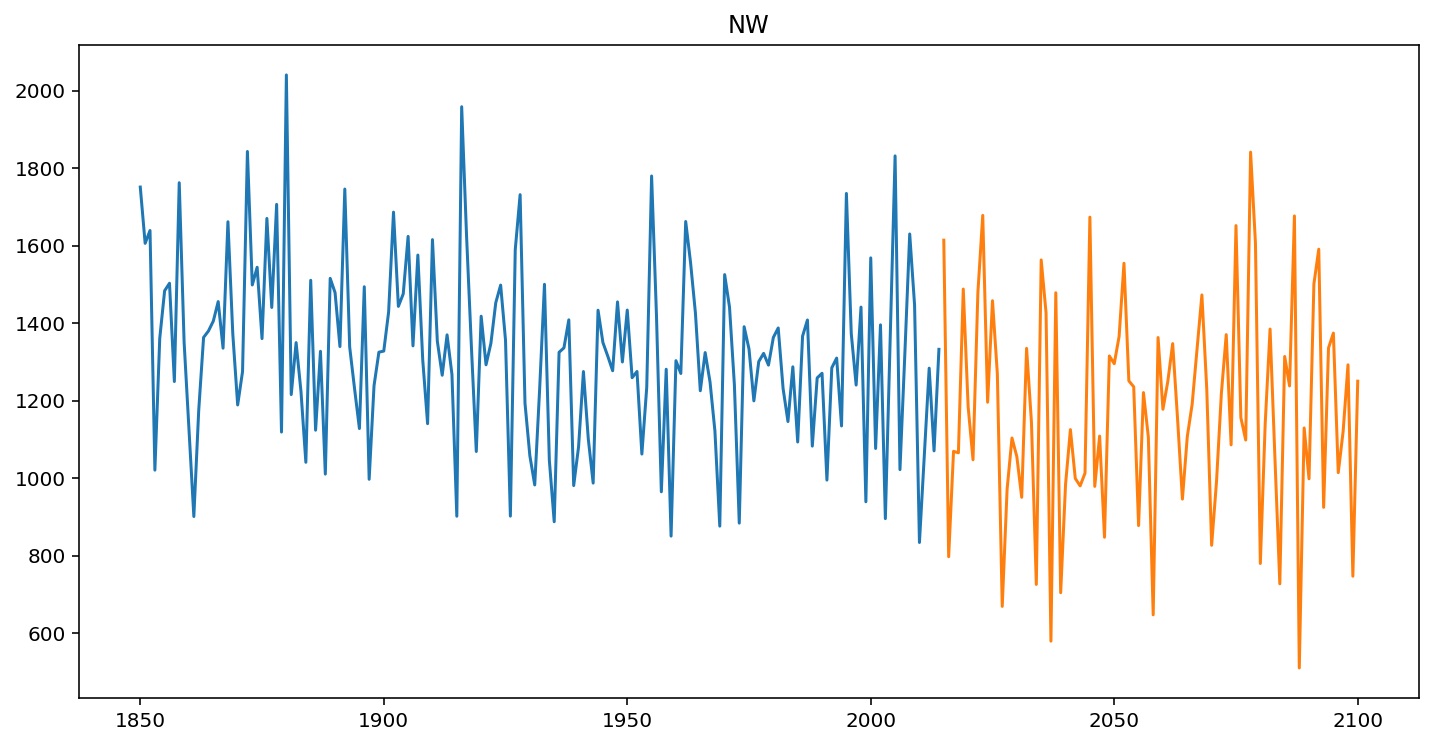

In [117]:
for item in dir_ls:
    df =  pd.DataFrame({'date': ls[item].time, 'pr':ls[item]*86400})
    df['date'] =  df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    df.to_csv('NorESM2-LM-hist-' + item + '.csv')
    df = df.groupby(df['date'].dt.year).sum()

    df2 = pd.DataFrame({'date':ssp245_pix[item].time, 'pr':ssp245_pix[item]*86400})
    df2['date'] =  df2['date'].astype(str)
    df2['date'] = pd.to_datetime(df2['date'])
    df2.to_csv('NorESM2-LM-ssp245-' + item + '.csv')

    df2 = df2.groupby(df2['date'].dt.year).sum()
    
    plt.plot(df.index, df.pr)
    plt.plot(df2.index, df2.pr)
    plt.title(item)
    plt.show()

# plt.plot(ls['N'].time, ls['N'] * 86400)
# plt.show()